In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
import os
import cv2 as cv
import numpy as np

# Carga de la data a clasificar

Para el caso a desarrollar vamos a trabajar con la data **natural images**, la misma esta conformada por 8 clases:
<li> airplane 
<li> car 
<li> cat 
<li> dog 
<li> flower 
<li> fruit 
<li> motorbike
<li> person 

La solucion que se busca para este problema es la clasificación utilizando una red convolucional.

# Exploración preliminar de la data

Para ello definimos una función que nos permita tomar una muestra del dataset y graficarla

In [3]:
def display_random_images_folder(root_path, samples_per_folder=5):
    """
    Muestra imagenes aleatorias de cada clase, considerando que .
    
    Parameters:
    - root_path: Ruta, La ruta al directorio raíz que contiene la información.
    - samples_per_folder: Númoro de muestras a mostrar por cada subcarpeta/clase (default is 5).
    """
    
    labels = os.listdir(root_path)
    
    fig = plt.figure(figsize=(20, 15))

    for row_index in range(len(labels)):
        subdirectory = str(row_index + 1)
        folder_path =os.path.join(root_path, labels[row_index])
        
        if os.path.isdir(folder_path):  # Check if the path is a directory
            images = os.listdir(folder_path)
            for sample_index in range(samples_per_folder):
                if images:  # Ensure there are images to sample
                    random_number = random.randint(0, len(images) - 1)
                    image_path = os.path.join(folder_path, images[random_number])
                    image = cv.imread(image_path)
                    
                    ax = fig.add_subplot(len(labels), samples_per_folder, samples_per_folder * row_index + sample_index + 1)
                    ax.axis("off")
                    ax.set_title(str(labels[row_index]))
                    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()


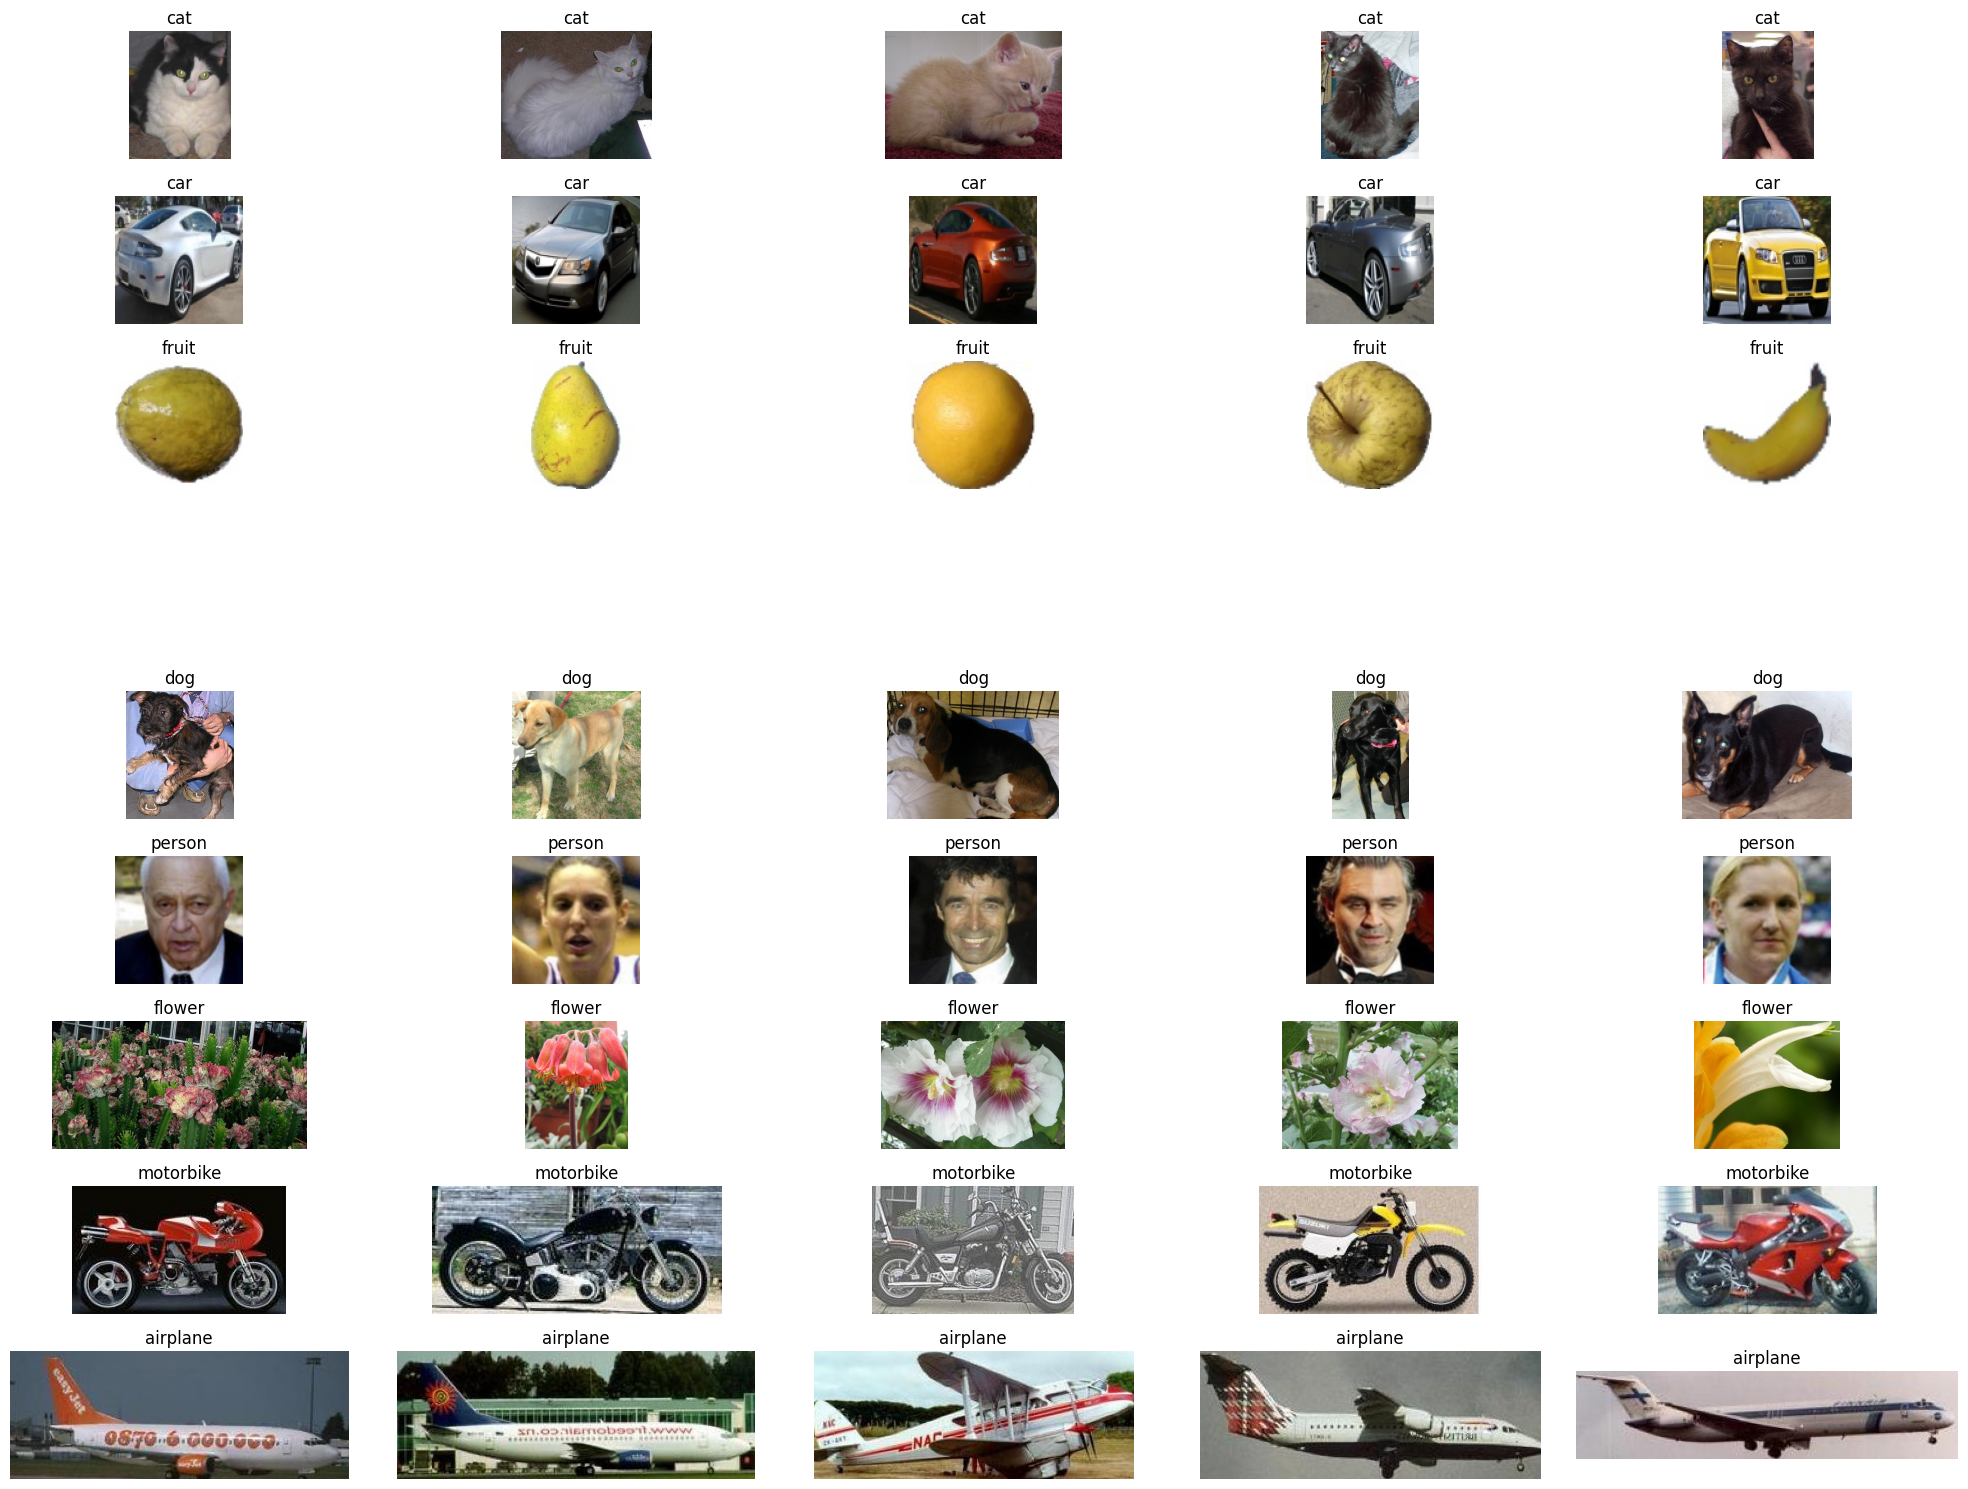

In [4]:
root_path = r"/Users/carlosvillalobos/Documents/UBA/VC2/TP/natural_images"
# Ploteo de la muestra
display_random_images_folder(root_path)

Es posible evidenciar que existe una disparidad de dimensiones que debemos considerar.

Definimos una función que grafique como estan distribuidas las dimensiones por clase

In [5]:

def get_image_sizes_by_class(root_path):
    class_sizes = {}
    supported_extensions = ('.png', '.jpg', '.jpeg')  # Extensiones soportadas
    total_images = 0
    valid_images = 0

    for root, dirs, files in os.walk(root_path):
        class_name = os.path.basename(root)  
        if files:
            class_sizes[class_name] = []
        for file in files:
            if file.lower().endswith(supported_extensions):
                total_images += 1
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        class_sizes[class_name].append(img.size)  
                        valid_images += 1
                except Exception as e:
                    print(f"Error al abrir la imagen {file_path}: {e}")

    print(f"Total de imágenes encontradas: {total_images}")
    print(f"Imágenes válidas procesadas: {valid_images}")
    print(f"Imágenes no válidas o con errores: {total_images - valid_images}")
    
    return class_sizes


Total de imágenes encontradas: 6899
Imágenes válidas procesadas: 6899
Imágenes no válidas o con errores: 0


IndexError: index 8 is out of bounds for axis 0 with size 8

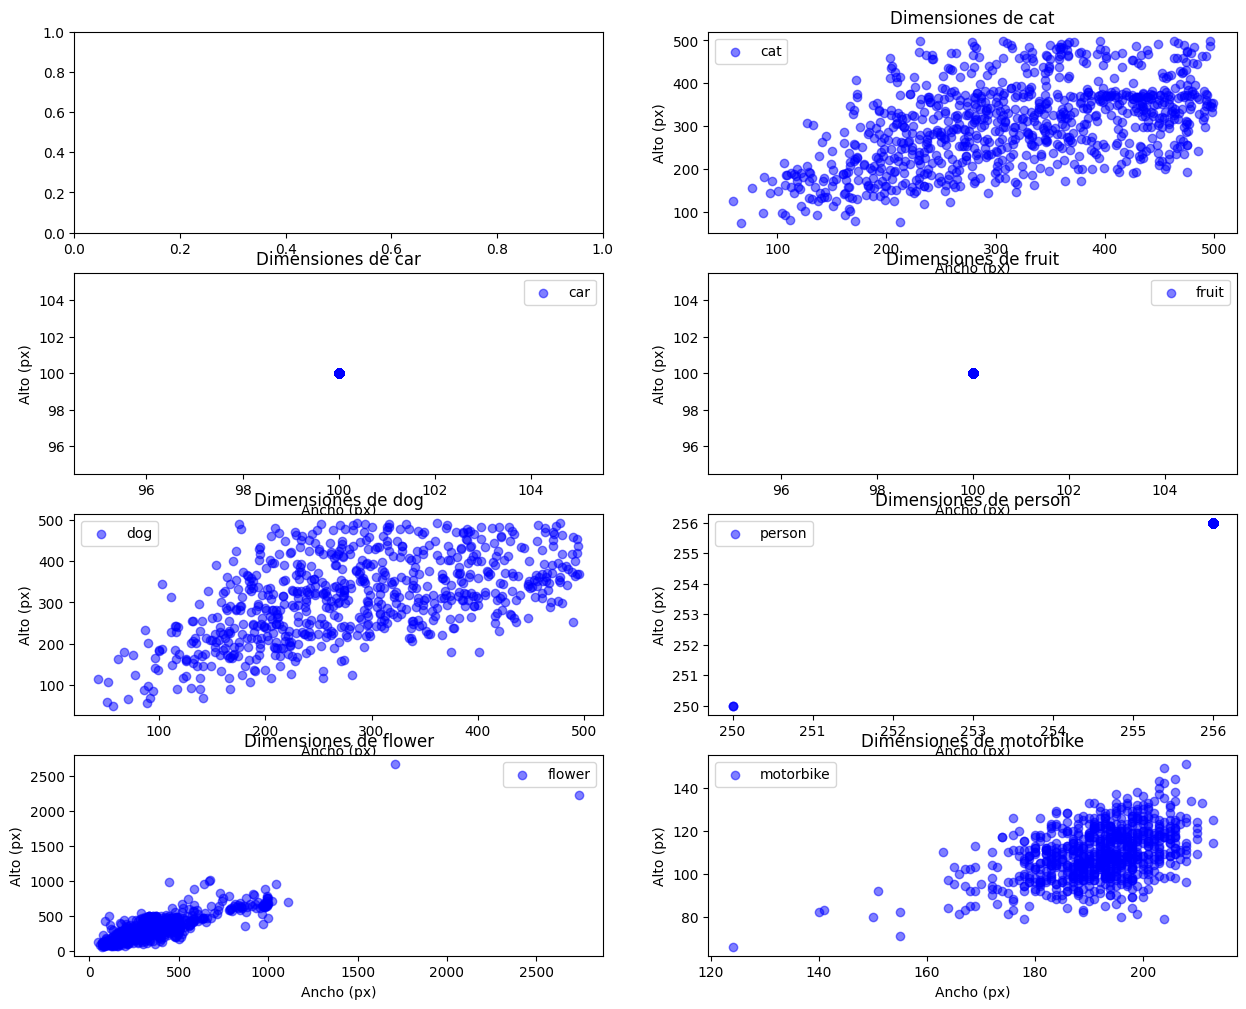

In [6]:
class_sizes = get_image_sizes_by_class(root_path)

# Graficar scatterplots de dimensiones por clase
if class_sizes:
    num_classes = len(class_sizes)
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))  
    axes = axes.flatten()  
    
    for i, (class_name, sizes) in enumerate(class_sizes.items()):
        #Verificar que haya imágenes en la clase
        if sizes:  
            widths, heights = zip(*sizes)
            
            axes[i].scatter(widths, heights, alpha=0.5, label=f'{class_name}', color='b')
            axes[i].set_title(f'Dimensiones de {class_name}')
            axes[i].set_xlabel('Ancho (px)')
            axes[i].set_ylabel('Alto (px)')
            axes[i].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes válidas para procesar.")

Se desprende de este gráfico que la distribución de dimensiones es bastante heterogenea.

La clase **airplane** muestra dimension de ancho variando entre 220 y 380 (aprox) y la de alto entre 50 y 320 (aprox)

La clase **car** tiene una dimension 100x100

La clase **cat** muestra dimension de ancho variando entre 60 y 500 (aprox) y la de alto entre 60 y 500 (aprox)

La clase **dog** muestra dimension de ancho variando entre 60 y 500 (aprox) y la de alto entre 60 y 500 (aprox)

La clase **flower** muestra dimension de ancho variando entre 50 y 1000 (aprox) y la de alto entre 50 y 1000 (aprox)

La clase **fruit** tiene una dimension 100x100

La clase **motorbike** muestra dimension de ancho variando entre 120 y 256 (aprox) y la de alto entre 20 y 160

La clase **person** tiene una dimensión 250x250 o 256x256

Por lo que es importante considerar en la solución un óptimo uso del resize para que nuestro modelo recoja correctamente las características.



# Validación del nivel de balance del dataset

In [7]:
# Cargar el dataset
dataset = torchvision.datasets.ImageFolder(root=root_path)

# Verificar la distribución de las clases
class_counts = torch.bincount(torch.tensor(dataset.targets))
print(f'Distribución original de clases: {class_counts}')

Distribución original de clases: tensor([ 727,  968,  885,  702,  843, 1000,  788,  986])


Es notorio que las clases no se encuentran del todo balanceadas, por lo que sería necesario realizar alguna técnica de balanceo, en particular se plantea realizar un WeightedRadonsomSampling para corregir este desbalance.

In [8]:
def get_loaders2(root_path, batch_size, test_size=0.2, random_seed=42):
    """
    Crea DataLoaders balanceados para entrenamiento y no balanceados para prueba.
    
    Args:
        root_path (str): Ruta al directorio del dataset.
        batch_size (int): Tamaño del batch para los DataLoaders.
        test_size (float, opcional): Proporción del dataset para el conjunto de prueba. Default es 0.2.
        random_seed (int, opcional): Semilla para la reproducibilidad. Default es 42.
    
    Returns:
        train_loader (DataLoader): DataLoader balanceado para entrenamiento.
        test_loader (DataLoader): DataLoader para prueba.
        class_counts_train (torch.Tensor): Conteo de clases en el conjunto de entrenamiento.
        class_counts_test (torch.Tensor): Conteo de clases en el conjunto de prueba.
    """
    
    # Definir transformaciones
    my_transforms = transforms.Compose([
        transforms.Resize((300, 300)),  # Redimensiona todas las imágenes a 224x224
        transforms.ToTensor(),
    ])
    
    # Cargar el dataset completo
    full_dataset = datasets.ImageFolder(root=root_path, transform=my_transforms)
    
    # Obtener todas las etiquetas
    targets = np.array(full_dataset.targets)
    
    # Dividir índices en entrenamiento y prueba manteniendo la distribución de clases
    train_indices, test_indices = train_test_split(
        np.arange(len(targets)),
        test_size=test_size,
        stratify=targets,
        random_state=random_seed
    )
    
    # Crear subconjuntos para entrenamiento y prueba
    train_subset = Subset(full_dataset, train_indices)
    test_subset = Subset(full_dataset, test_indices)
    
    # Obtener las etiquetas de los subconjuntos
    train_targets = targets[train_indices]
    test_targets = targets[test_indices]
    
    # Calcular la distribución de clases en el conjunto de entrenamiento
    class_counts_train = torch.bincount(torch.tensor(train_targets))
    print(f'Distribución original de clases en entrenamiento: {class_counts_train}')
    
    # Calcular pesos 
    class_weights = 1.0 / class_counts_train.float()
    
    # Normaliza los pesos para que la suma sea igual al número de clases
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    
    # Asigna los pesos a cada muestra en el conjunto de entrenamiento
    sample_weights = [class_weights[label] for label in train_targets]
    sample_weights = torch.tensor(sample_weights, dtype=torch.float)
    
    # Crea el sampler ponderado
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # Crea DataLoader para entrenamiento con sampler
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=4,
        pin_memory=True
    )
    
    # Crea DataLoader para prueba sin balanceo
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Calcular la distribución de clases en el conjunto de prueba
    class_counts_test = torch.bincount(torch.tensor(test_targets))
    print(f'Distribución original de clases en prueba: {class_counts_test}')
    
    return train_loader, test_loader, class_counts_train, class_counts_test


In [9]:
batch_size = 32  
test_size = 0.2  
    
  
train_loader, test_loader, class_counts_train, class_counts_test = get_loaders2(
        root_path=root_path,
        batch_size=batch_size,
        test_size=test_size,
        random_seed=42
    )
    
    # Verificar la distribución en el DataLoader balanceado de entrenamiento
balanced_counts_train = [0] * len(class_counts_train)
for data, labels in train_loader:
    for label in labels:
        balanced_counts_train[label] += 1   
    
print(f'Distribución en el DataLoader de entrenamiento balanceado: {balanced_counts_train}')
    
    # Verificar la distribución en el DataLoader de prueba
balanced_counts_test = [0] * len(class_counts_test)
for data, labels in test_loader:
    for label in labels:
        balanced_counts_test[label] += 1
    
print(f'Distribución en el DataLoader de prueba: {balanced_counts_test}')


Distribución original de clases en entrenamiento: tensor([582, 774, 708, 562, 674, 800, 630, 789])
Distribución original de clases en prueba: tensor([145, 194, 177, 140, 169, 200, 158, 197])
Distribución en el DataLoader de entrenamiento balanceado: [704, 687, 680, 686, 666, 687, 725, 684]
Distribución en el DataLoader de prueba: [145, 194, 177, 140, 169, 200, 158, 197]


In [10]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.ReLU()(self.bn4(self.conv4(x)))
        
        x = self.pool(x)  # Adaptive pooling
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [26]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        
        
def validate_model(model, val_loader, criterion, device='cpu'):
    # Modelo de evaluación
    model.eval()  
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No calcular gradientes durante la validación
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
        

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = CustomCNN(num_classes=8).to(device)  # Cambia num_classes según tu problema
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [33]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device)

In [21]:
validate_model(model, test_loader, criterion, device=device)

Validation Loss: 0.3291, Accuracy: 88.70%
